In [1]:

%pprint
import sys
if (osp.join(os.pardir, 'py') not in sys.path): sys.path.insert(1, osp.join(os.pardir, 'py'))

Pretty printing has been turned OFF


In [2]:

from FRVRS import (nu, fu, DataFrame, display)
import os
from datetime import timedelta

In [3]:

# Get all CSVs into one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(842663, 112)



# Time to First Treatment

In [4]:

# Time to first treatment
if nu.pickle_exists('time_to_treatment_df'):
    time_to_treatment_df = nu.load_object('time_to_treatment_df')
else:
    
    # Initialize an empty list to store rows of data
    rows_list = []
    
    # Loop through the grouped data (grouped by UUID and scene)
    for (session_uuid, scene_id), scene_df in frvrs_logs_df.groupby(fu.scene_groupby_columns):
        
        # Get the logger version
        logger_version = fu.get_logger_version(scene_df)
        is_scene_aborted = fu.get_is_scene_aborted(scene_df)
        scene_type = fu.get_scene_type(scene_df)
        
        # Create a boolean mask for 'INJURY_TREATED' action type
        action_mask_series = (scene_df.action_type == 'INJURY_TREATED')
        
        # Check if there are any rows with 'INJURY_TREATED' action type
        if scene_df[action_mask_series].shape[0]:
            # Initialize a dictionary to store row data
            row_dict = {}
            
            # Store logger_version, session_uuid, and scene_id
            for cn in fu.scene_groupby_columns: row_dict[cn] = eval(cn)
            row_dict['logger_version'] = logger_version
            row_dict['is_scene_aborted'] = is_scene_aborted
            row_dict['scene_type'] = scene_type
            
            # Calculate and add the time to first treatment
            first_treatment = fu.get_first_treatment(scene_df)
            row_dict['first_treatment'] = first_treatment
            
            # Create a mask for the row with the first treatment
            mask_series = action_mask_series & (scene_df.action_tick == first_treatment)
            
            # Get the patient ID of the first treatment and add it
            patient_id = scene_df[mask_series].patient_id.squeeze()
            for cn in fu.patient_groupby_columns: row_dict[cn] = eval(cn)
            
            # Create a mask for rows with the same patient_id
            mask_series = (scene_df.patient_id == patient_id)
            
            # Calculate the time to the first notice and add it
            first_notice = fu.get_first_patient_interaction(scene_df[mask_series])
            row_dict['first_notice'] = first_notice
            
            # Calculate the time to treatment by subtracting first_notice from first_treatment
            time_to_treatment = first_treatment - first_notice
            row_dict['time_to_treatment'] = time_to_treatment
            
            # Append the row dictionary to the list of rows
            rows_list.append(row_dict)
    
    # Create a Data Frame from the list of row dictionaries
    time_to_treatment_df = DataFrame(rows_list)
    nu.store_objects(time_to_treatment_df=time_to_treatment_df)

Pickling to C:\Users\DaveBabbitt\Documents\GitHub\itm-analysis-reporting\saves\pkl\time_to_treatment_df.pkl


In [5]:

time_to_treatment_df.sort_values('time_to_treatment')

session_uuid  scene_id  logger_version  \
295  6e3a5d8b-12c4-4afd-9a2e-619eb5b72b23            1             1.0   
277  67ed9702-0908-454a-8069-7ca4a6f2bee9            2             1.3   
292  6d21f440-1c45-4c53-ad64-4edb92a94e25            1             1.0   
498  c090fff8-5f81-40c5-b313-5fb7ce42ab9f            1             1.0   
208  48c426ae-e88c-49bd-8010-37dc7b042c95            1             1.0   
..                                    ...          ...             ...   
329  75b3227f-2f3c-4fe0-b9b8-9e0fe3baa210            2             1.3   
275  677d1c18-f292-4bcb-924d-52f5e762533f            2             1.3   
400  95a83c35-3575-461a-9a53-8aa09c8afa62            1             1.0   
359  84282ed0-0e63-44e0-8b39-5156e3c868d0            2             1.3   
416  9f03c005-21d8-4934-8bb9-7152347726d1            2             1.3   

     is_scene_aborted   scene_type  first_treatment     patient_id  \
295             False       Triage            30718  Gloria_2 Root   
277             False       Triage           222429    Mike_5 Root   
292             False       Triage            28351    Mike_2 Root   
498             False       Triage            33510  Gloria_2 Root   
208             False       Triage            49908  Gloria_2 Root   
..                ...          ...              ...            ...   
329             False       Triage           609133    Lily_4 Root   
275             False       Triage           716069    Mike_7 Root   
400             False  Orientation           289874    Mike_1 Root   
359             False       Triage           749317    Gary_3 Root   
416             False       Triage           683526    Mike_5 Root   

     first_notice  time_to_treatment  
295         20571              10147  
277        212151              10278  
292         17132              11219  
498         22047              11463  
208         38444              11464  
..            ...                ...  
329        352038             257095  
275        441771             274298  
400         13172             276702  
359        446817             302500  
416        290037             393489  

[673 rows x 9 columns]

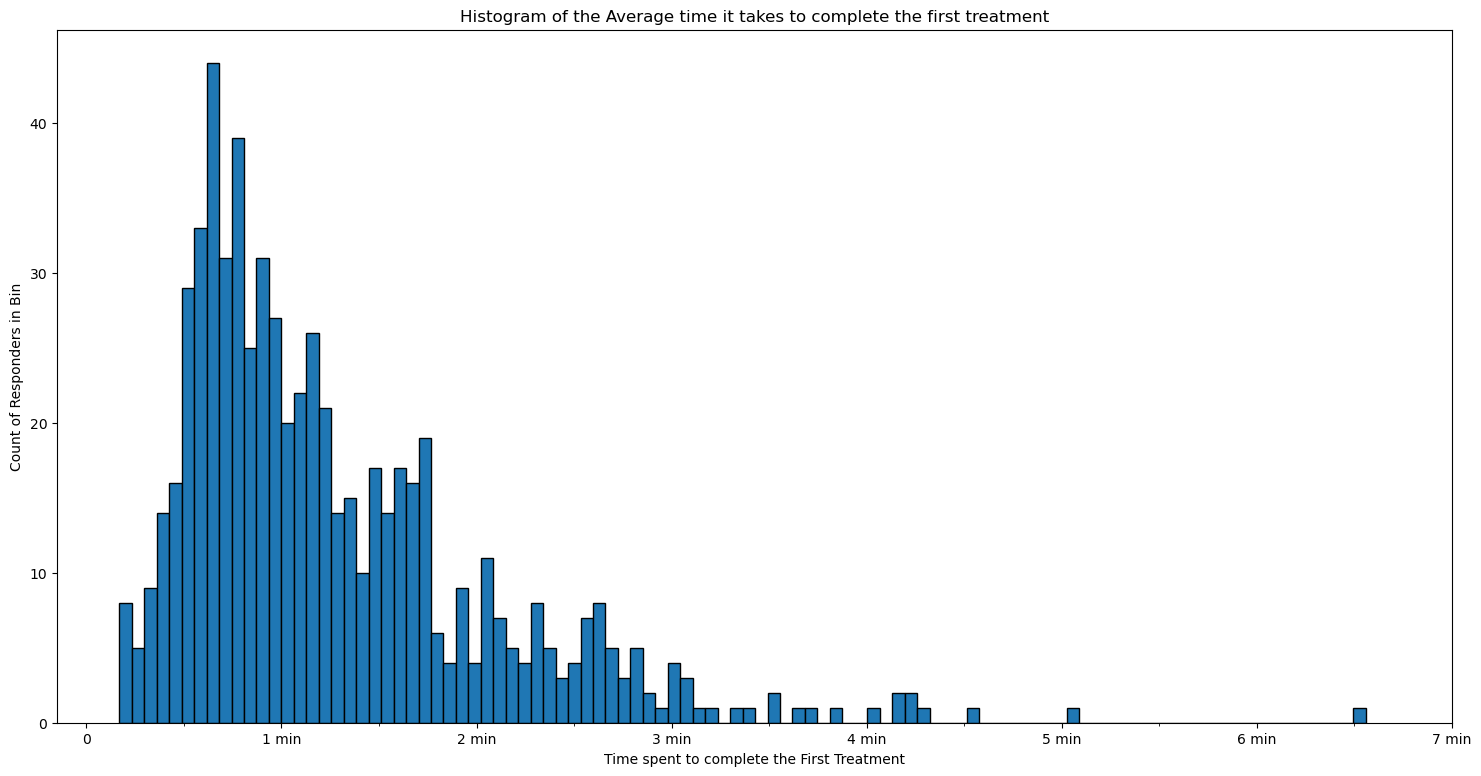

In [6]:

# Histogram of the time it takes to complete first treatment
xlabel = 'Time spent to complete the First Treatment'

# Make it so that the x-axis tick labels appear like 0, 30, 1 min, 1:30, 2 min, etc
get_xtick_text = lambda text_obj: fu.format_timedelta_lambda(
    timedelta(milliseconds=int(text_obj.get_position()[0]))
)

title = 'Histogram of the Average time it takes to complete the first treatment'
ylabel = 'Count of Responders in Bin'
mask_series = (time_to_treatment_df.scene_type == 'Triage') & (time_to_treatment_df.is_scene_aborted == False)
ax = nu.plot_histogram(
    time_to_treatment_df[mask_series], 'time_to_treatment', xlabel=xlabel, xtick_text_fn=get_xtick_text, title=title, ylabel=ylabel, xticks_are_temporal=True
)

In [7]:

# Can you provide the following statistics for this distribution: mean, median, mode, SD, Interquartile range?
mask_series = (time_to_treatment_df.scene_type == 'Triage') & (time_to_treatment_df.is_scene_aborted == False)
columns_list = [
    'time_to_treatment'
]
df = time_to_treatment_df[mask_series][columns_list]
fu.show_time_statistics(df, columns_list)

mean mode median   SD min 25%   50%   75%   max
time_to_treatment  1:16   35   1:01  ±48  10  41  1:01  1:37  6:33

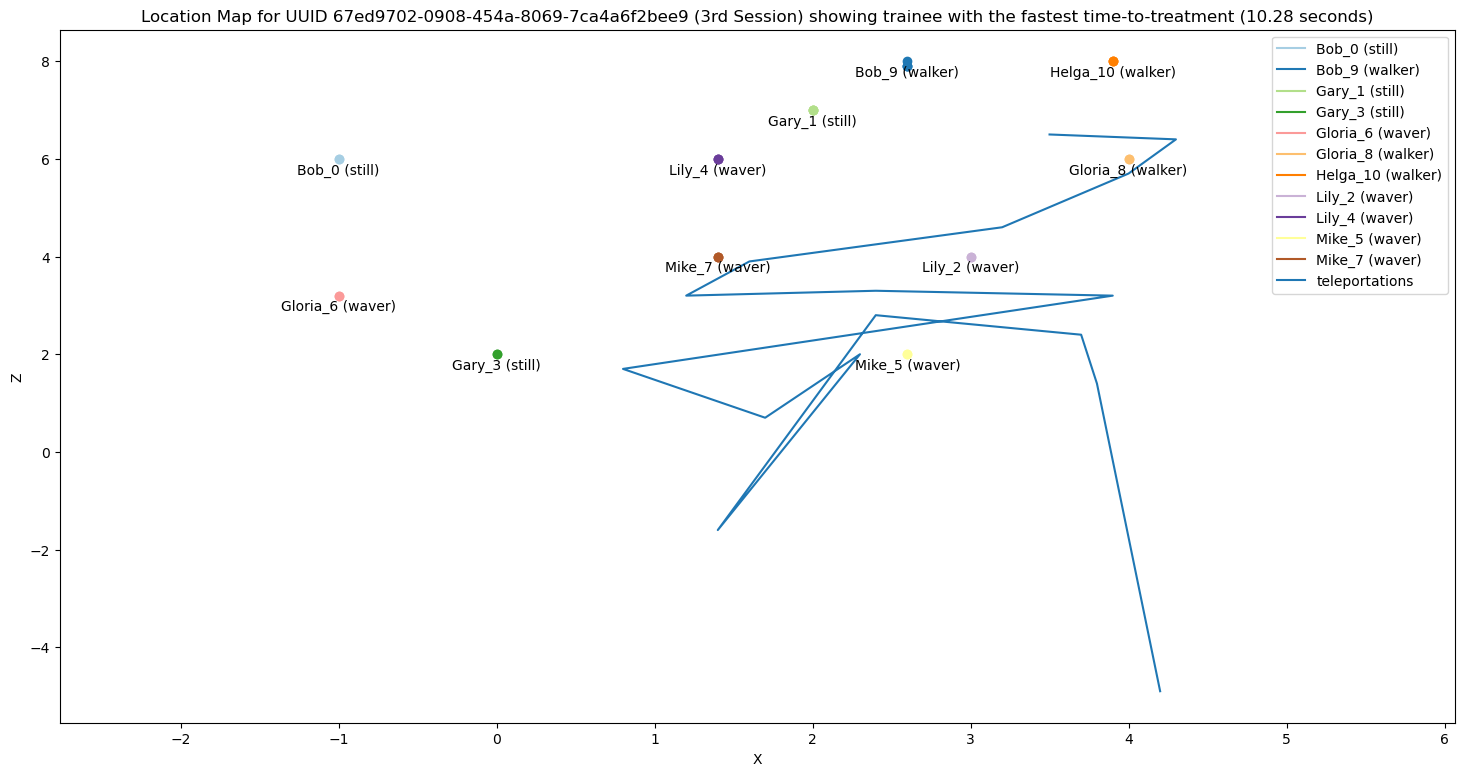

In [6]:

# Get scene with the fastest time to treatment, v1.3
mask_series = (time_to_treatment_df.logger_version == 1.3)
fu.visualize_extreme_player_movement(
    frvrs_logs_df, time_to_treatment_df, 'time_to_treatment', mask_series=mask_series, is_ascending=True,
    humanize_type='precisedelta', title_str='fastest time-to-treatment', verbose=False
)

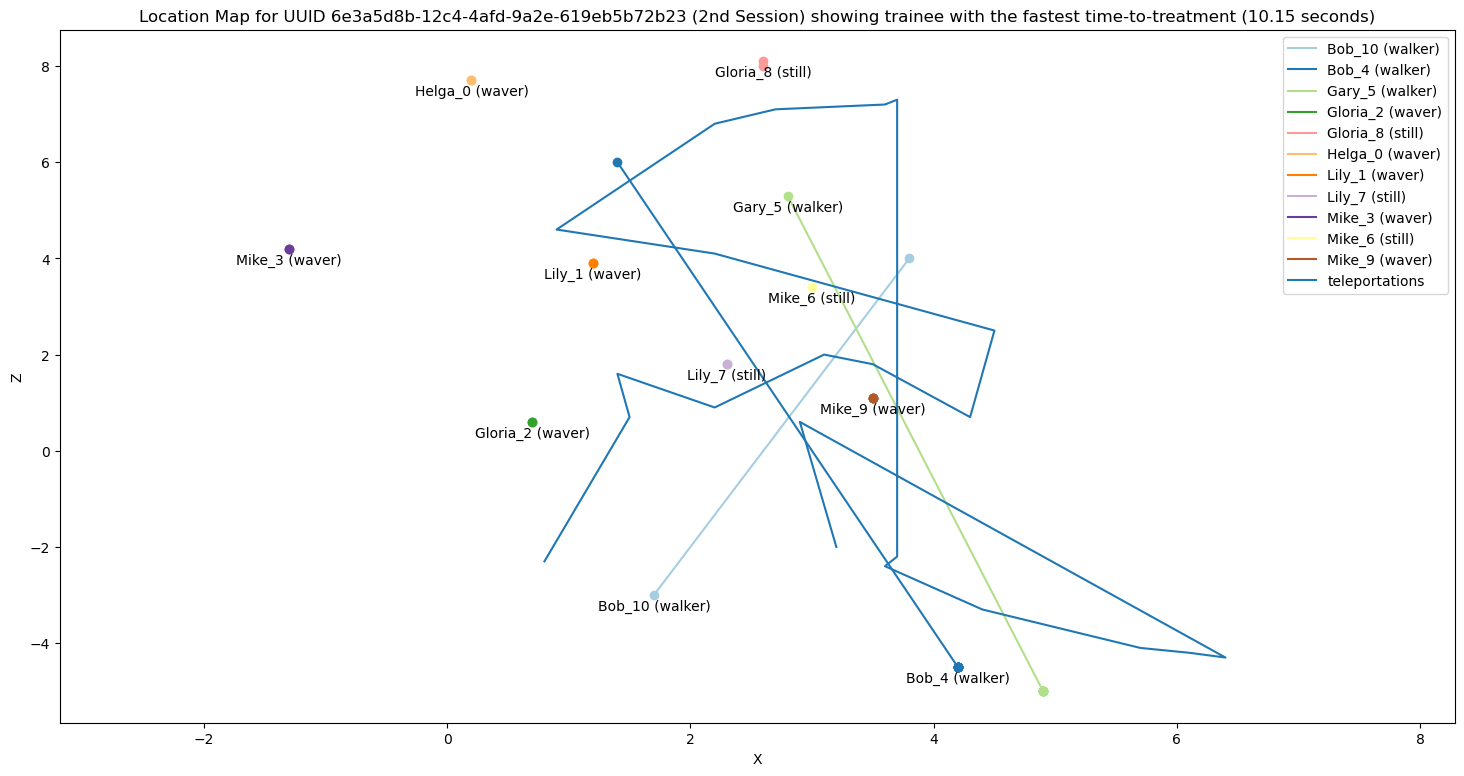

In [7]:

# Get scene with the fastest time to treatment, v1.0
mask_series = (time_to_treatment_df.logger_version == 1.0)
fu.visualize_extreme_player_movement(
    frvrs_logs_df, time_to_treatment_df, 'time_to_treatment', mask_series=mask_series, is_ascending=True,
    humanize_type='precisedelta', title_str='fastest time-to-treatment', verbose=False
)

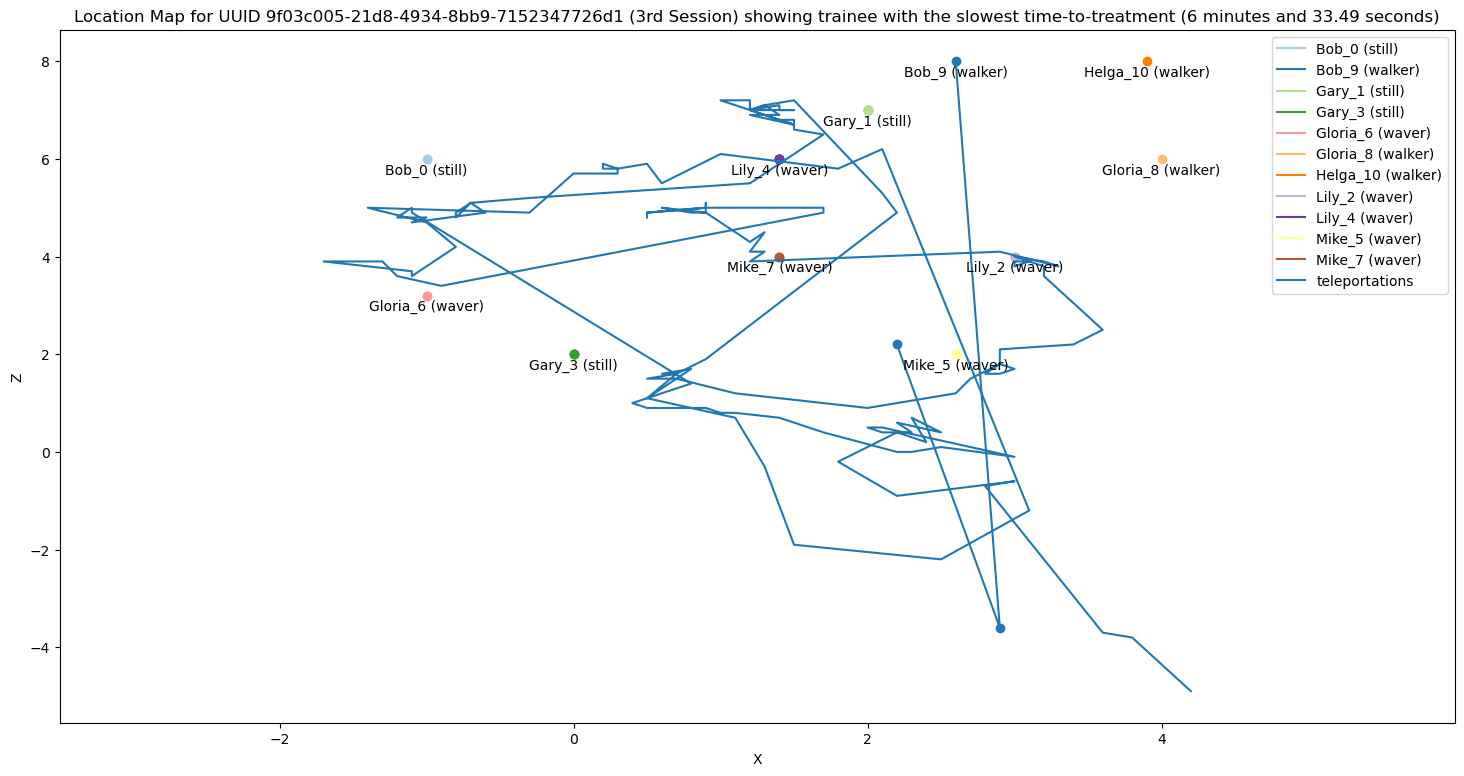

In [8]:

# Get scene with the slowest time to treatment, v1.3
mask_series = (time_to_treatment_df.logger_version == 1.3)
fu.visualize_extreme_player_movement(
    frvrs_logs_df, time_to_treatment_df, 'time_to_treatment', mask_series=mask_series, is_ascending=False,
    humanize_type='precisedelta', title_str='slowest time-to-treatment', verbose=False
)

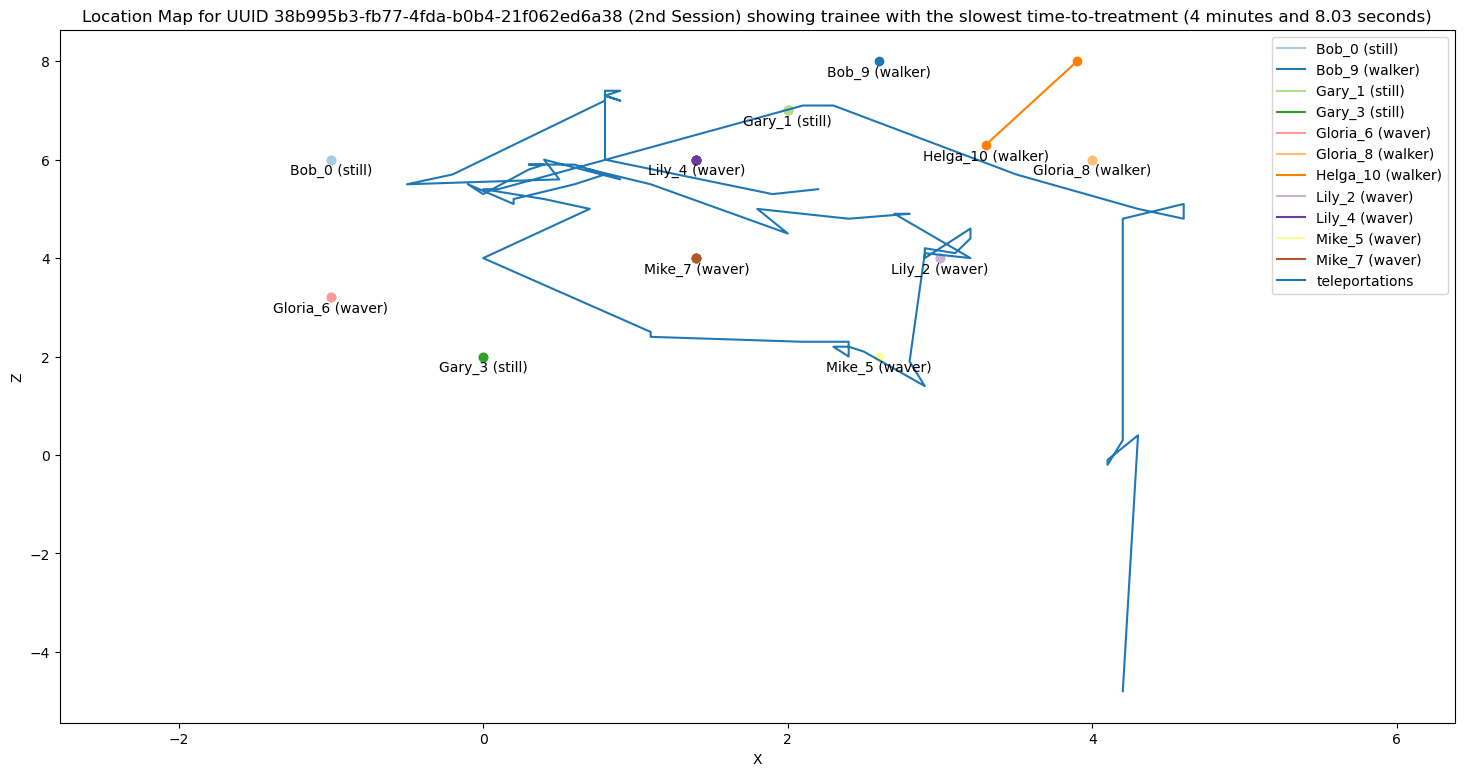

In [9]:

# Get scene with the slowest time to treatment, v1.0
mask_series = (time_to_treatment_df.logger_version == 1.0)
fu.visualize_extreme_player_movement(
    frvrs_logs_df, time_to_treatment_df, 'time_to_treatment', mask_series=mask_series, is_ascending=False,
    humanize_type='precisedelta', title_str='slowest time-to-treatment', verbose=False
)